In [1]:
# coding:utf-8

import keras
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras import backend as K
import os
import glob
import matplotlib.gridspec as gridspec
import shutil
from keras.utils import plot_model
import cv2
from skimage import io
from skimage import transform
from scipy.misc import imresize
from skimage import io
import skimage

Using TensorFlow backend.


<class 'keras.engine.topology.Layer'>


In [2]:
# フォルダの中にある画像を順次読み込む
# カテゴリーは0から始める

#参考
#https://qiita.com/supersaiakujin/items/fc54116df9ca6958a68d
#http://testpy.hatenablog.com/entry/2017/06/02/001901
#https://qiita.com/zaburo/items/0b9db87d0a52191b164b
# 画像の反転と回転の実装、またはdata argumentation の実装を行う
X = []
Y = []
name_class = []
#下、後でコード量を減らす
# 対象Aの画像
rate = 0.2
label = 0
for dir in os.listdir("data/train"):
#     print(dir)
    if dir == ".DS_Store":
        continue
    name_class.append(dir)
    for picture in list_pictures("data/train/"+dir):
#         print(picture)
    #     img =load_img(picture, target_size=(64,64))
        img =imresize(skimage.io.imread(picture),(224,224), interp='nearest')
#         img =imresize(skimage.io.imread(picture),(64,64), interp='nearest')
    #     img_raw = skimage.io.imread
#         print(img_to_array(skimage.transform.rotate(img, angle=0, resize=False, center=None)).shape)
        for i in range(358,360):
            #回転のみ
            X.append(img_to_array(skimage.transform.rotate(img, angle=i, resize=False, center=None)))
            Y.append(label )
#             #回転と上下の反転
            X.append(img_to_array(cv2.flip(skimage.transform.rotate(img, angle=i, resize=False, center=None),0)))
            Y.append(label )
#             #回転と左右の反転
#             X.append(img_to_array(cv2.flip(skimage.transform.rotate(img, angle=i, resize=False, center=None),1)))
#             Y.append(label )
#             #拡大
            X.append(img_to_array(skimage.transform.warp(skimage.transform.rotate(img, angle=i, resize=False, center=None), skimage.transform.AffineTransform(scale=(1-rate, 1-rate), translation=(64,64)))))
            Y.append(label )
    label += 1

# # arrayに変換
# X.shape()
print(name_class)
X = np.asarray(X)
print(X.shape)
# print(X)
Y = np.asarray(Y)
# print(Y)

['CurryPowder', 'rice', 'onion', 'potato', 'carot']
(1152, 224, 224, 3)


In [3]:
# 画素値を0から1の範囲に変換
X = X.astype('float32')
X = X / 255.0

# クラスの形式を変換
Y = np_utils.to_categorical(Y, 5)

# 学習用データとテストデータ
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=111)
# print(X_train.reshape((32,32,3)).shape)
print(y_train.shape)

(1036, 5)


In [4]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
import resnet

# input image dimensions
img_rows, img_cols = 224, 224
# The CIFAR10 images are RGB.
img_channels = 3

batch_size = 32
nb_classes = 5
nb_epoch = 1
data_augmentation = True

model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

history = model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, y_test),
              shuffle=True,
              )

/Users/kokimadono/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1036 samples, validate on 116 samples
Epoch 1/1

1036/1036 [==============================] - ETA: 0s - loss: 1.6613 - acc: 0.6622 - val_loss: 12.1397 - val_acc: 0.2414


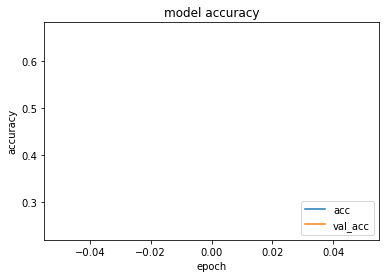

In [6]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right') #グラフの凡例を用意している
plt.show()

In [8]:
# # テストデータに適用
# predict_classes = model.predict_classes(X_test)

# # マージ。yのデータは元に戻す
# mg_df = pd.DataFrame({'predict': predict_classes, 'class': np.argmax(y_test, axis=1)})

# # confusion matrix
# pd.crosstab(mg_df['class'], mg_df['predict'])

In [9]:
def train_and_evaluate_model(model,data,labels,data_test,labels_test):
# def train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test]):
    model.fit(data, labels, batch_size=32, epochs=30,verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
    return model.evaluate(data_test, labels_test, verbose=1)  # Evaluate the trained model on the test set!
#損失値と評価の値を算出している
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold
# kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
# print(cross_val_score(model, image_list, label_list,cv=kfold)).mean()  
from sklearn.cross_validation import StratifiedKFold
label = np.r_[np.repeat(0,16), np.repeat(1,0)]
skf = StratifiedKFold(label, n_folds=15, shuffle=False)
total_score = 0
rep = 0
print("success")
for i, (train, test) in enumerate(skf):
    print("TRAIN:", train, "TEST:", test)
    total_score += train_and_evaluate_model(model, X_train[train], y_train[train], X_train[test], y_train[test])[1]
    rep+=1
# print(total_score/rep)
print("%.10f" % (total_score/rep))

/Users/kokimadono/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


success
TRAIN: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [0 1]
Train on 12 samples, validate on 2 samples
Epoch 1/30

12/12 [==============================] - ETA: 0s - loss: 1.1568 - acc: 0.7500 - val_loss: 16.8516 - val_acc: 0.0000e+00
Epoch 2/30

12/12 [==============================] - ETA: 0s - loss: 1.1220 - acc: 0.9167 - val_loss: 16.8503 - val_acc: 0.0000e+00
Epoch 3/30

12/12 [==============================] - ETA: 0s - loss: 1.0746 - acc: 0.9167 - val_loss: 16.8489 - val_acc: 0.0000e+00
Epoch 4/30

12/12 [==============================] - ETA: 0s - loss: 1.0164 - acc: 0.9167 - val_loss: 16.8475 - val_acc: 0.0000e+00
Epoch 5/30

12/12 [==============================] - ETA: 0s - loss: 0.9543 - acc: 0.9167 - val_loss: 16.8461 - val_acc: 0.0000e+00
Epoch 6/30

12/12 [==============================] - ETA: 0s - loss: 0.8977 - acc: 0.9167 - val_loss: 16.8447 - val_acc: 0.0000e+00
Epoch 7/30

12/12 [==============================] - ETA: 0s - loss: 0.8519 - acc: 1.0000 - va


1/1 [==============================] - ETA: 0s
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [3]
Train on 13 samples, validate on 2 samples
Epoch 1/30

13/13 [==============================] - ETA: 0s - loss: 0.6213 - acc: 1.0000 - val_loss: 6.6626 - val_acc: 0.0000e+00
Epoch 2/30

13/13 [==============================] - ETA: 0s - loss: 0.6191 - acc: 1.0000 - val_loss: 6.6774 - val_acc: 0.0000e+00
Epoch 3/30

13/13 [==============================] - ETA: 0s - loss: 0.6170 - acc: 1.0000 - val_loss: 6.6888 - val_acc: 0.0000e+00
Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.6149 - acc: 1.0000 - val_loss: 6.6978 - val_acc: 0.0000e+00
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.6127 - acc: 1.0000 - val_loss: 6.7043 - val_acc: 0.0000e+00
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.6106 - acc: 1.0000 - val_loss: 6.7073 - val_acc: 0.0000e+00
Epoch 7/30

13/13 [==============================] - ETA: 0


1/1 [==============================] - ETA: 0s
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15] TEST: [5]
Train on 13 samples, validate on 2 samples
Epoch 1/30

13/13 [==============================] - ETA: 0s - loss: 0.5043 - acc: 1.0000 - val_loss: 5.6188 - val_acc: 0.0000e+00
Epoch 2/30

13/13 [==============================] - ETA: 0s - loss: 0.5026 - acc: 1.0000 - val_loss: 5.5609 - val_acc: 0.0000e+00
Epoch 3/30

13/13 [==============================] - ETA: 0s - loss: 0.5008 - acc: 1.0000 - val_loss: 5.5053 - val_acc: 0.0000e+00
Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.4991 - acc: 1.0000 - val_loss: 5.4519 - val_acc: 0.0000e+00
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.4974 - acc: 1.0000 - val_loss: 5.4004 - val_acc: 0.0000e+00
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.4957 - acc: 1.0000 - val_loss: 5.3505 - val_acc: 0.0000e+00
Epoch 7/30

13/13 [==============================] - ETA: 0


1/1 [==============================] - ETA: 0s
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15] TEST: [7]
Train on 13 samples, validate on 2 samples
Epoch 1/30

13/13 [==============================] - ETA: 0s - loss: 0.4130 - acc: 1.0000 - val_loss: 3.5891 - val_acc: 0.0000e+00
Epoch 2/30

13/13 [==============================] - ETA: 0s - loss: 0.4117 - acc: 1.0000 - val_loss: 3.5752 - val_acc: 0.0000e+00
Epoch 3/30

13/13 [==============================] - ETA: 0s - loss: 0.4104 - acc: 1.0000 - val_loss: 3.5606 - val_acc: 0.0000e+00
Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.4091 - acc: 1.0000 - val_loss: 3.5453 - val_acc: 0.0000e+00
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.4078 - acc: 1.0000 - val_loss: 3.5293 - val_acc: 0.0000e+00
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.4065 - acc: 1.0000 - val_loss: 3.5129 - val_acc: 0.0000e+00
Epoch 7/30

13/13 [==============================] - ETA: 0

TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15] TEST: [9]
Train on 13 samples, validate on 2 samples
Epoch 1/30

13/13 [==============================] - ETA: 0s - loss: 0.3441 - acc: 1.0000 - val_loss: 2.7898 - val_acc: 0.5000
Epoch 2/30

13/13 [==============================] - ETA: 0s - loss: 0.3431 - acc: 1.0000 - val_loss: 2.7856 - val_acc: 0.5000
Epoch 3/30

13/13 [==============================] - ETA: 0s - loss: 0.3421 - acc: 1.0000 - val_loss: 2.7814 - val_acc: 0.5000
Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.3411 - acc: 1.0000 - val_loss: 2.7774 - val_acc: 0.5000
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.3401 - acc: 1.0000 - val_loss: 2.7734 - val_acc: 0.5000
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.3392 - acc: 1.0000 - val_loss: 2.7695 - val_acc: 0.5000
Epoch 7/30

13/13 [==============================] - ETA: 0s - loss: 0.3382 - acc: 1.0000 - val_loss: 2.7658 - val_acc: 0.5000
Epoc

Epoch 2/30

13/13 [==============================] - ETA: 0s - loss: 0.2909 - acc: 1.0000 - val_loss: 2.6554 - val_acc: 0.5000
Epoch 3/30

13/13 [==============================] - ETA: 0s - loss: 0.2901 - acc: 1.0000 - val_loss: 2.6551 - val_acc: 0.5000
Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.2894 - acc: 1.0000 - val_loss: 2.6548 - val_acc: 0.5000
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.2886 - acc: 1.0000 - val_loss: 2.6545 - val_acc: 0.5000
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.2879 - acc: 1.0000 - val_loss: 2.6542 - val_acc: 0.5000
Epoch 7/30

13/13 [==============================] - ETA: 0s - loss: 0.2871 - acc: 1.0000 - val_loss: 2.6540 - val_acc: 0.5000
Epoch 8/30

13/13 [==============================] - ETA: 0s - loss: 0.2864 - acc: 1.0000 - val_loss: 2.6538 - val_acc: 0.5000
Epoch 9/30

13/13 [==============================] - ETA: 0s - loss: 0.2856 - acc: 1.0000 - val_loss: 2.6536 - 

Epoch 4/30

13/13 [==============================] - ETA: 0s - loss: 0.2495 - acc: 1.0000 - val_loss: 2.7182 - val_acc: 0.5000
Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.2489 - acc: 1.0000 - val_loss: 2.7193 - val_acc: 0.5000
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.2483 - acc: 1.0000 - val_loss: 2.7203 - val_acc: 0.5000
Epoch 7/30

13/13 [==============================] - ETA: 0s - loss: 0.2477 - acc: 1.0000 - val_loss: 2.7212 - val_acc: 0.5000
Epoch 8/30

13/13 [==============================] - ETA: 0s - loss: 0.2471 - acc: 1.0000 - val_loss: 2.7220 - val_acc: 0.5000
Epoch 9/30

13/13 [==============================] - ETA: 0s - loss: 0.2465 - acc: 1.0000 - val_loss: 2.7226 - val_acc: 0.5000
Epoch 10/30

13/13 [==============================] - ETA: 0s - loss: 0.2459 - acc: 1.0000 - val_loss: 2.7231 - val_acc: 0.5000
Epoch 11/30

13/13 [==============================] - ETA: 0s - loss: 0.2454 - acc: 1.0000 - val_loss: 2.7236 

Epoch 5/30

13/13 [==============================] - ETA: 0s - loss: 0.2173 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.5000
Epoch 6/30

13/13 [==============================] - ETA: 0s - loss: 0.2168 - acc: 1.0000 - val_loss: 0.6953 - val_acc: 0.5000
Epoch 7/30

13/13 [==============================] - ETA: 0s - loss: 0.2164 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 8/30

13/13 [==============================] - ETA: 0s - loss: 0.2159 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 9/30

13/13 [==============================] - ETA: 0s - loss: 0.2154 - acc: 1.0000 - val_loss: 0.6864 - val_acc: 0.5000
Epoch 10/30

13/13 [==============================] - ETA: 0s - loss: 0.2150 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.5000
Epoch 11/30

13/13 [==============================] - ETA: 0s - loss: 0.2145 - acc: 1.0000 - val_loss: 0.6803 - val_acc: 0.5000
Epoch 12/30

13/13 [==============================] - ETA: 0s - loss: 0.2140 - acc: 1.0000 - val_loss: 0.6772